<a href="https://colab.research.google.com/github/Rangulov/PhMathInfo/blob/main/Homework_9%20(%D0%90%D0%B2%D1%82%D0%BE%D1%8D%D0%BD%D0%BA%D0%BE%D0%B4%D0%B5%D1%80)/%D0%A4%D0%9C%D0%98_%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_%D0%90%D0%B2%D1%82%D0%BE%D1%8D%D0%BD%D0%BA%D0%BE%D0%B4%D0%B5%D1%80%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Stroke"]

In [5]:
df = pd.read_csv('dataset.csv')

## Data exploration

In [6]:
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [7]:
df = df.drop(columns=['id'])

In [8]:
print(df.shape)
print(df.describe())

(43400, 11)
                age  hypertension  heart_disease  avg_glucose_level  \
count  43400.000000  43400.000000   43400.000000       43400.000000   
mean      42.217894      0.093571       0.047512         104.482750   
std       22.519649      0.291235       0.212733          43.111751   
min        0.080000      0.000000       0.000000          55.000000   
25%       24.000000      0.000000       0.000000          77.540000   
50%       44.000000      0.000000       0.000000          91.580000   
75%       60.000000      0.000000       0.000000         112.070000   
max       82.000000      1.000000       1.000000         291.050000   

                bmi        stroke  
count  41938.000000  43400.000000  
mean      28.605038      0.018041  
std        7.770020      0.133103  
min       10.100000      0.000000  
25%       23.200000      0.000000  
50%       27.700000      0.000000  
75%       32.900000      0.000000  
max       97.600000      1.000000  


## Ести ли пропуски?

In [9]:
df.isnull().values.any()

np.True_

In [10]:
df = df.dropna()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29072 entries, 1 to 43399
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             29072 non-null  object 
 1   age                29072 non-null  float64
 2   hypertension       29072 non-null  int64  
 3   heart_disease      29072 non-null  int64  
 4   ever_married       29072 non-null  object 
 5   work_type          29072 non-null  object 
 6   Residence_type     29072 non-null  object 
 7   avg_glucose_level  29072 non-null  float64
 8   bmi                29072 non-null  float64
 9   smoking_status     29072 non-null  object 
 10  stroke             29072 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 2.7+ MB


In [12]:
df['smoking_status'].value_counts()


,count
smoking_status,
never smoked,15747
formerly smoked,7099
smokes,6226


In [13]:
df['gender'].value_counts()

,count
gender,
Female,17852
Male,11213
Other,7


In [14]:
df['ever_married'].value_counts()

,count
ever_married,
Yes,21690
No,7382


In [15]:
df['work_type'].value_counts()

,count
work_type,
Private,18954
Self-employed,5204
Govt_job,4196
children,617
Never_worked,101


In [16]:
df['Residence_type'].value_counts()

,count
Residence_type,
Urban,14595
Rural,14477


In [17]:
df = df[df['gender']!='Other']

In [18]:
df['smoking_status'] = df['smoking_status'].replace(["never smoked", "formerly smoked", "smokes"],[0,1,2])
df['gender'] = df['gender'].replace(["Female", "Male"],[0,1])
df['ever_married'] = df['ever_married'].replace(["Yes", "No"],[1,0])
df['work_type'] = df['work_type'].replace(df['work_type'].unique(),[4,3,2,1,0])
df['Residence_type'] = df['Residence_type'].replace(df['Residence_type'].unique(),[0,1])

/tmp/ipython-input-3698412459.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['smoking_status'] = df['smoking_status'].replace(["never smoked", "formerly smoked", "smokes"],[0,1,2])
/tmp/ipython-input-3698412459.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'] = df['gender'].replace(["Female", "Male"],[0,1])
/tmp/ipython-input-3698412459.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objec

## Class distribution ( 0 - non stroke, 1 - stroke)

In [19]:
df['stroke'].value_counts()

,count
stroke,
0,28517
1,548


/tmp/ipython-input-4024981480.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['stroke'], sort = True)


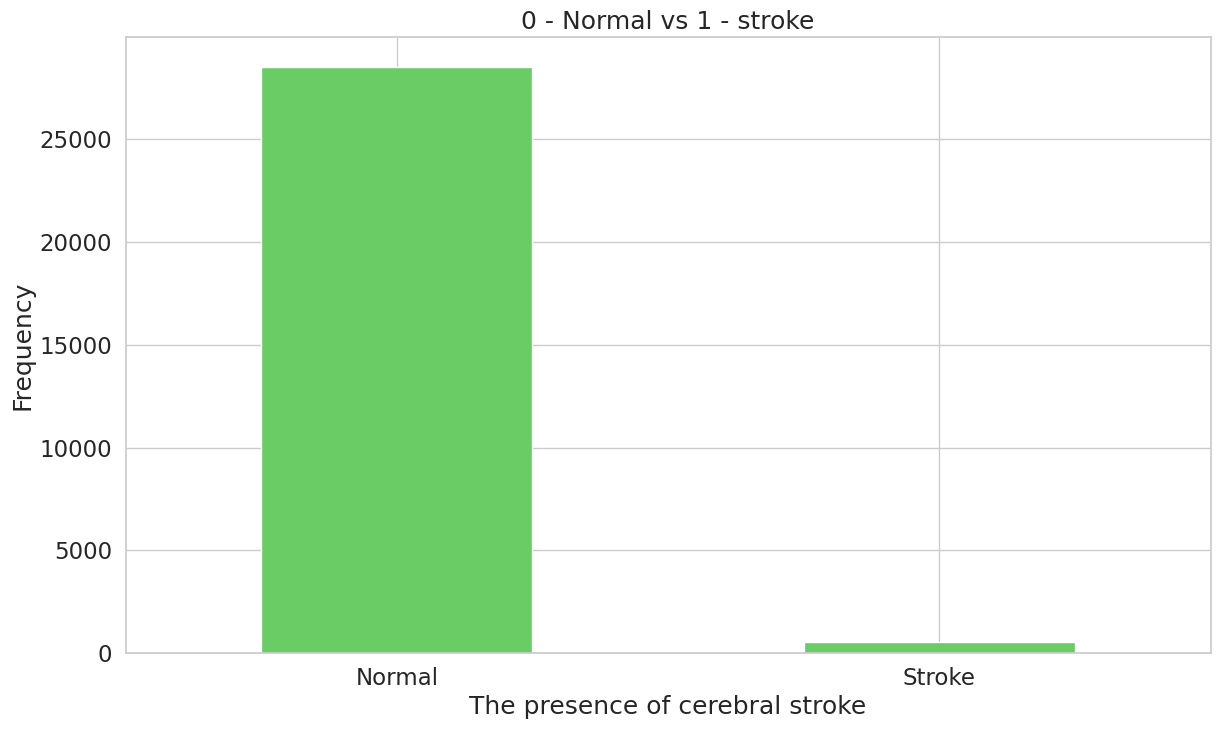

In [20]:
count_classes = pd.value_counts(df['stroke'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color="g")
plt.title("0 - Normal vs 1 - stroke")
plt.xticks(range(2), LABELS)
plt.xlabel("The presence of cerebral stroke")
plt.ylabel("Frequency");

Наш набор данных очень сильно несбалансирован в пользу отрицательного (0, то есть нормального) класса. Это требует дальнейшего изучения данных

In [21]:
strokeDF = df[df['stroke'] == 1]
normalDF = df[df['stroke'] == 0]

In [22]:
strokeDF.shape

(548, 11)

In [23]:
normalDF.shape

(28517, 11)

## Preprocessing

In [24]:
transactionData = df

### Разделите набор данных на наборы обучающих и тестовых данных.

Мы разделили набор данных как обучение = 80% и тест = 20%. В обучающем наборе данных будут только обычные транзакции, а в тестовом наборе данных будут как обычные, так и мошеннические транзакции.

In [25]:
X_train, X_test = train_test_split(transactionData, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.stroke == 0]
X_train = X_train.drop(['stroke'], axis=1)
#print(type(X_train))
y_test = X_test['stroke']
X_test = X_test.drop(['stroke'], axis=1)

X_train = X_train.values
#print(type(X_train))
X_test = X_test.values
y_test = y_test.values
print(y_test.size)


5813


## Model
Мы построим автоэнкодер, состоящий из 4 полносвязных слоев с 10,7,4,7 нейронами. Первые 2 слоя действуют как кодировщик, а последние 2 слоя действуют как декодер. Обратите внимание, что последний слой имеет 10 узлов, соответствующих 10 функциям в элементе входных данных.

In [26]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(10, 7),
            nn.Tanh(),
            nn.Linear(7, 4),
            nn.LeakyReLU(),
            )

        self.decoder = nn.Sequential(
           nn.Linear(4, 7),
           nn.Tanh(),
           nn.Linear(7, 10),
           nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [27]:
model = Autoencoder().double()
#model = Autoencoder().double().cpu()

In [28]:
num_epochs = 100   # сколько эпох будем обучать. Результаты обучения на одной эпохе используются как начальные для следующей.
minibatch_size = 32
learning_rate = 1e-3

In [29]:

train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)


In [30]:

#test = data_utils.TensorDataset(torch.from_numpy(X_test).double(),torch.from_numpy(y_test).double())
#test_loader = data_utils.DataLoader(test, batch_size=minibatch_size, shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)

In [31]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=10e-05)


In [32]:
history = {}
history['train_loss'] = []
history['test_loss'] = []


In [33]:
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        #print(type(data))
        #data = Variable(data).cpu()
        #print(type(data))
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)


torch.save(model.state_dict(), './stroke_model.pth')

epoch [1/100], loss:1553.1203
epoch [2/100], loss:1339.7891
epoch [3/100], loss:1180.2856
epoch [4/100], loss:1044.5689
epoch [5/100], loss:926.7054
epoch [6/100], loss:825.1220
epoch [7/100], loss:736.1417
epoch [8/100], loss:658.8524
epoch [9/100], loss:590.8718
epoch [10/100], loss:531.5496
epoch [11/100], loss:479.6082
epoch [12/100], loss:433.8085
epoch [13/100], loss:394.0345
epoch [14/100], loss:359.2480
epoch [15/100], loss:329.7615
epoch [16/100], loss:302.8817
epoch [17/100], loss:276.3008
epoch [18/100], loss:255.5871
epoch [19/100], loss:237.1683
epoch [20/100], loss:216.6526
epoch [21/100], loss:198.9119
epoch [22/100], loss:183.5072
epoch [23/100], loss:169.9677
epoch [24/100], loss:157.4542
epoch [25/100], loss:145.6488
epoch [26/100], loss:134.6983
epoch [27/100], loss:124.6940
epoch [28/100], loss:115.3209
epoch [29/100], loss:106.5754
epoch [30/100], loss:98.5438
epoch [31/100], loss:91.1951
epoch [32/100], loss:84.3958
epoch [33/100], loss:77.5339
epoch [34/100], los

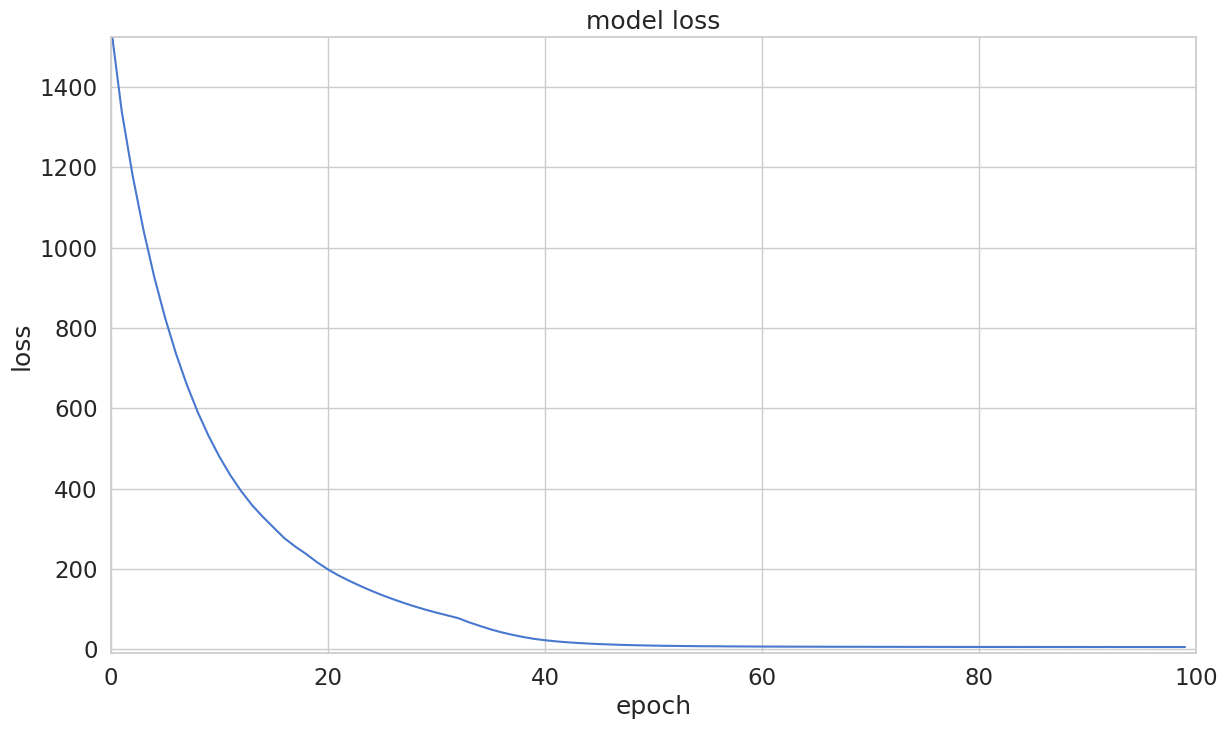

In [34]:
#history['train_loss']
#plt.plot(range(num_epochs),history['train_loss'],'ro',linewidth=2.0)
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([0,100,-10,1524])
#plt.legend(['train', 'test'], loc='upper right');
plt.show()

## Оценка модели

In [35]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
   # test_loss = 0
    for data in test_loader:
        inputs = data
        # print(inputs)
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        #print(loss)
        pred_losses['pred_loss'].append(loss)
        #pred_losses = model([y_test.size, y_test])
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['stroke'] = y_test

In [36]:
reconstructionErrorDF.describe()

,pred_loss,stroke
count,5813.000000,5813.000000
mean,5.820049,0.017203
std,9.304275,0.130038
min,0.079126,0.000000
25%,1.362125,0.000000
50%,2.998427,0.000000
75%,6.358640,0.000000
max,114.729773,1.000000


In [37]:
reconstructionErrorDF.describe()

,pred_loss,stroke
count,5813.000000,5813.000000
mean,5.820049,0.017203
std,9.304275,0.130038
min,0.079126,0.000000
25%,1.362125,0.000000
50%,2.998427,0.000000
75%,6.358640,0.000000
max,114.729773,1.000000


# Reconstruction Errors without Stroke

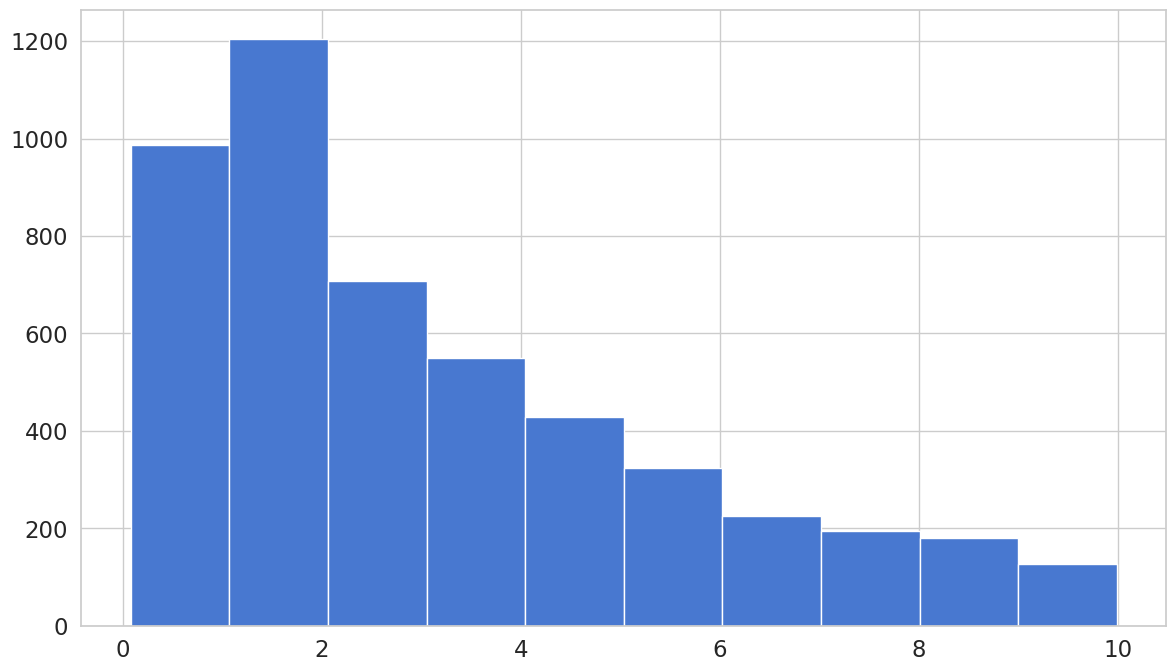

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['stroke']== 0) & (reconstructionErrorDF['pred_loss'] < 10)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10)

# Reconstruction Errors with Stroke

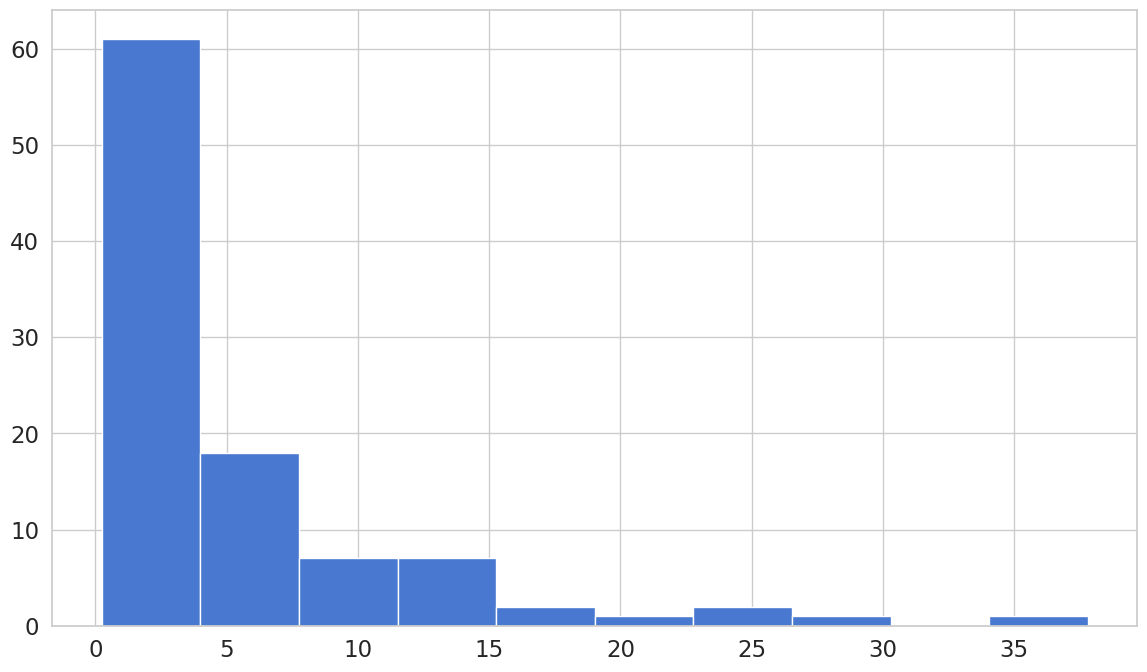

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['stroke']== 1) ]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10)

## ROC Curves

ROC-кривая очень часто используется для анализа бинарных классификаторов. Он рассматривает все возможные пороговые значения для данного классификатора и показывает процент ложных срабатываний (FPR) по сравнению с показателями истинно положительных результатов (TPR).

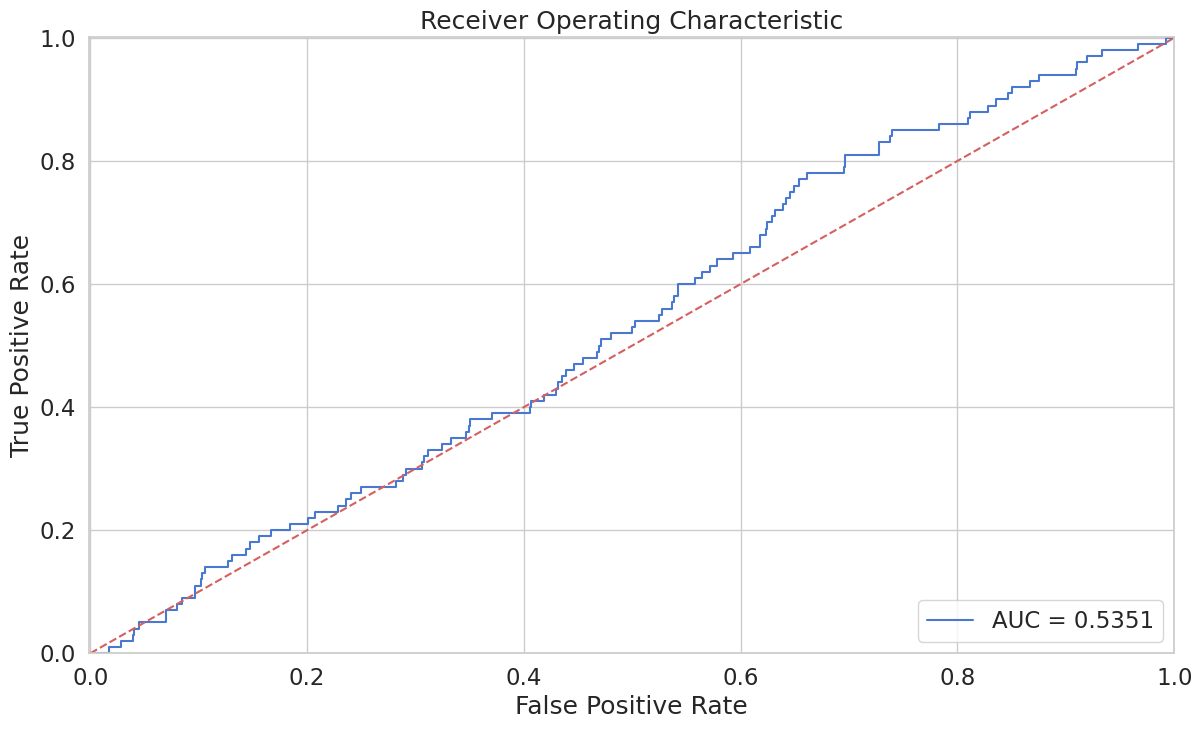

In [40]:
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.stroke, reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

## Precision vs Recall

Установка порога, который используется для принятия решения о классификации в модели, — это способ настроить компромисс между точностью (precision) и полнотой (recall) для данного классификатора.

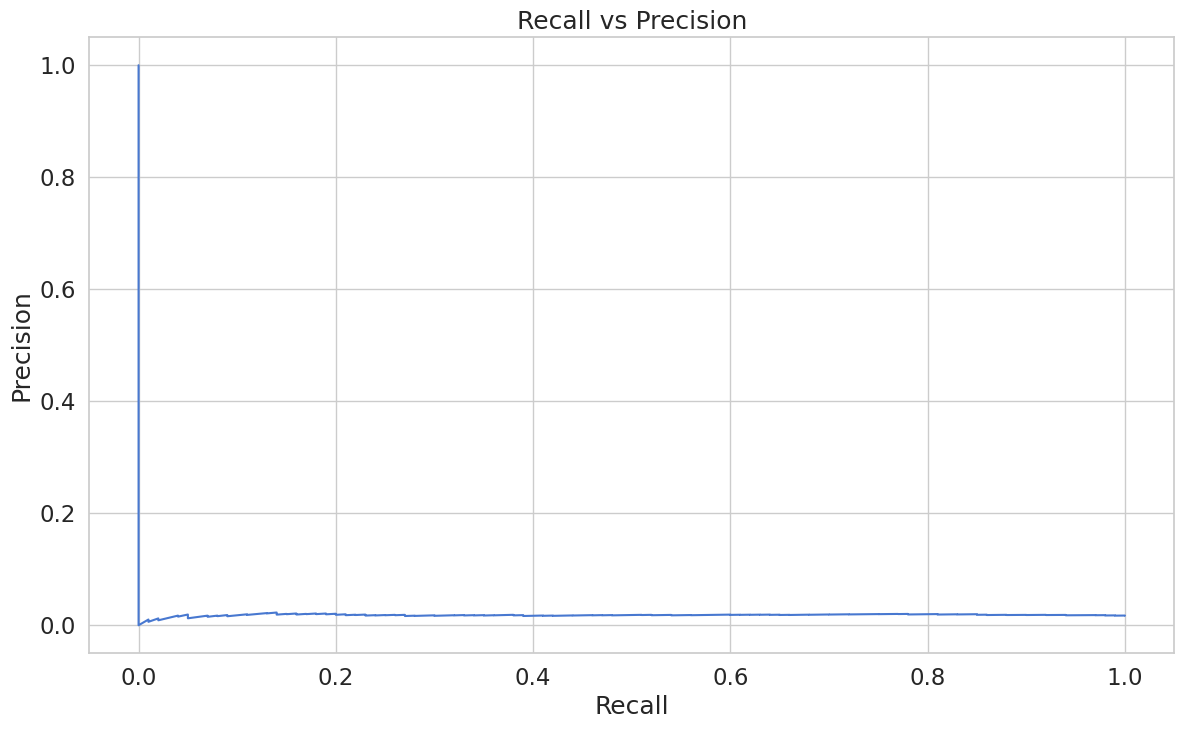

In [41]:
precision, recall, th = precision_recall_curve(reconstructionErrorDF.stroke, reconstructionErrorDF.pred_loss)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

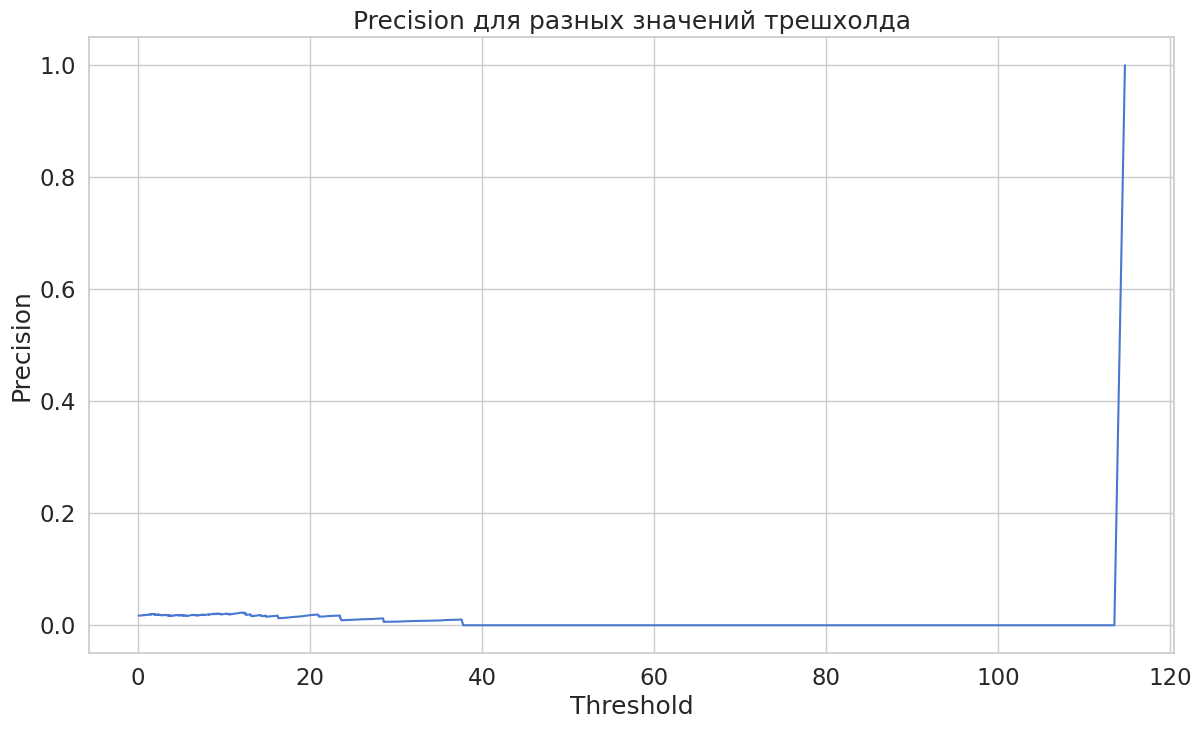

In [42]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision для разных значений трешхолда')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

Вы можете видеть, что по мере увеличения ошибки реконструкции повышается и наша precision. Давайте посмотрим на recall:


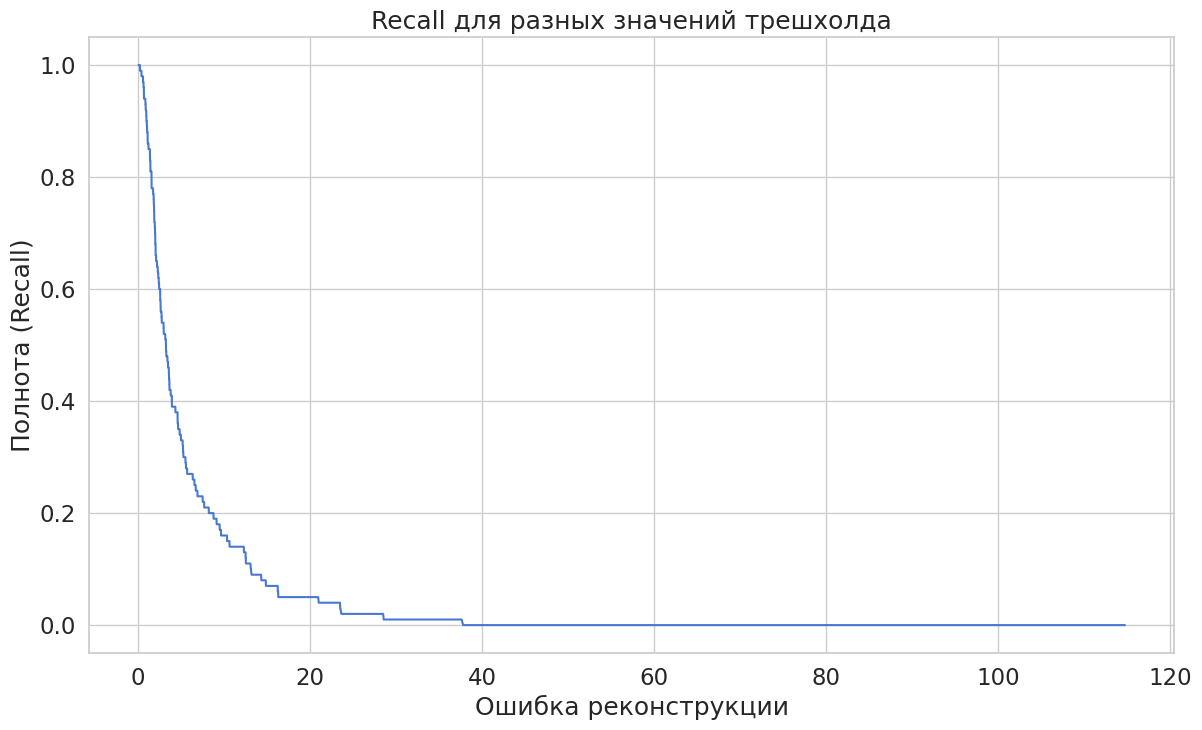

In [43]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall для разных значений трешхолда')
plt.xlabel('Ошибка реконструкции')
plt.ylabel('Полнота (Recall)')
plt.show()

Здесь мы имеем прямо противоположную ситуацию. По мере увеличения ошибки реконструкции recall (полнота) уменьшается.

## Используем модель для того, чтобы сделать предсказание

In [53]:
threshold = 10

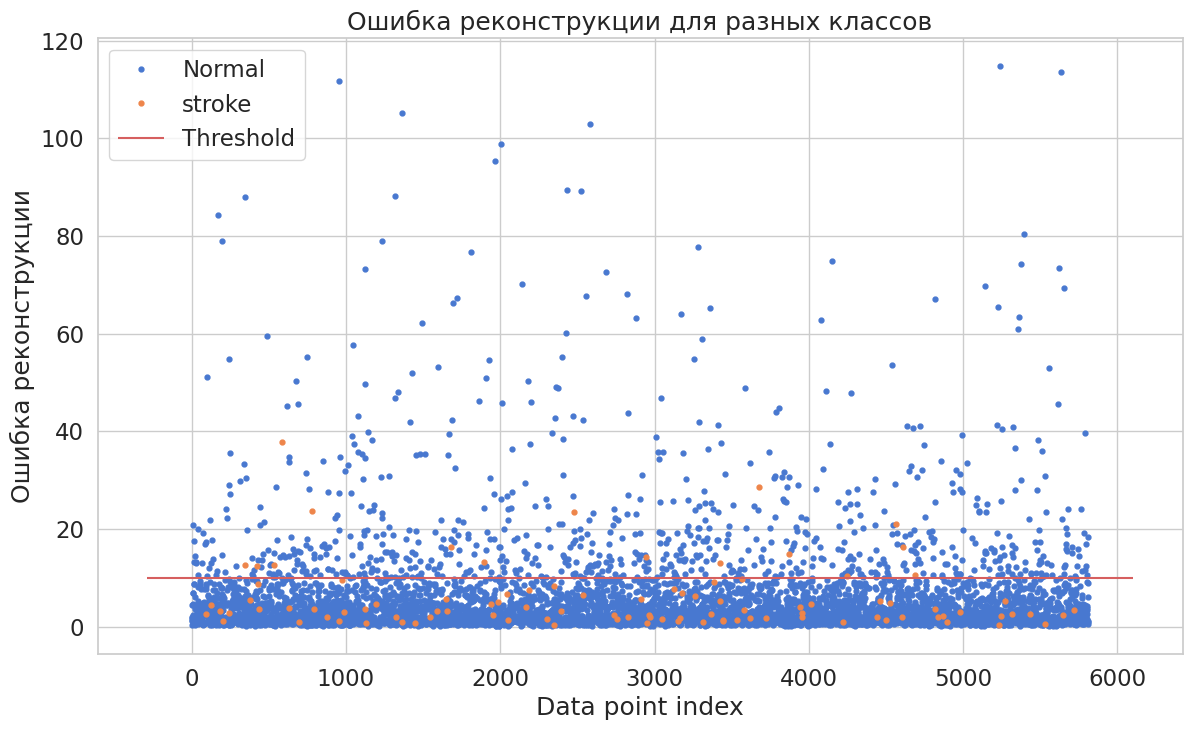

In [54]:
groups = reconstructionErrorDF.groupby('stroke')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "stroke" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Ошибка реконструкции для разных классов")
plt.ylabel("Ошибка реконструкции")
plt.xlabel("Data point index")
plt.show();

Построим и посмотрим confusion matrix:

/tmp/ipython-input-4267580219.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('Blues'));


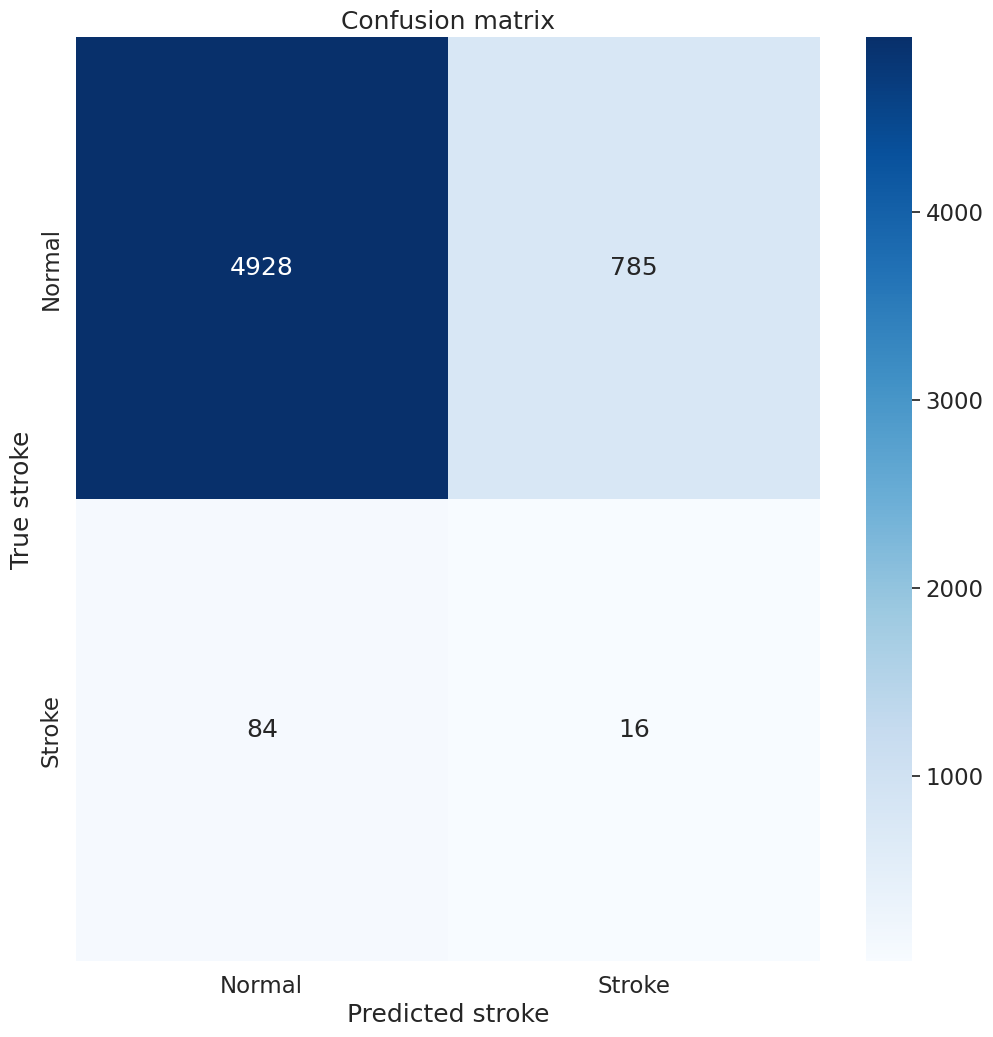

In [55]:

y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF.stroke, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",
            cmap=plt.cm.get_cmap('Blues'));
plt.title("Confusion matrix")
plt.ylabel('True stroke')
plt.xlabel('Predicted stroke')
plt.show()